Vettore 'same' (dal primo file):
[0.8851  0.89765 0.8534  ... 0.8673  0.7992  0.86085]

Vettore 'different' (dal secondo file):
[0.5395 0.5068 0.5577 ... 0.5769 0.5211 0.5138]

Vettore 'predictions' (concatenazione di 'same' e 'different'):
[0.8851  0.89765 0.8534  ... 0.5769  0.5211  0.5138 ]

Vettore 'expected' (1 per 'same' e 0 per 'different'):
[1. 1. 1. ... 0. 0. 0.]

DET CURVE WITH AVG SCORES
False Positive Rate (Pfa): [1.         0.99920886 0.99841772 ... 0.         0.         0.        ]
Miss Rate (Pmiss): [0.         0.         0.         ... 0.99841772 0.99920886 1.        ]

Equal Error Rate (EER): 0.0
BPCER (Binary Classification Error Rate) per i threshold dati: [0. 0. 0. 0. 0. 0. 0. 0. 0.]


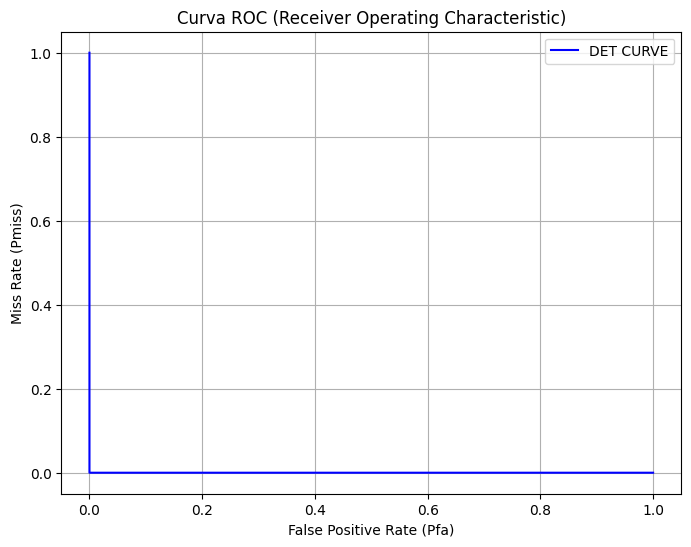

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def read_and_extract_values(file_path: str) -> np.ndarray:
    with open(file_path, 'r') as file:
        lines = file.readlines()[1:]  

    values = []
    for line in lines:
        columns = line.strip().split(';')
        
        if len(columns) >= 3:  
            values.append(columns[-1]) 
    
    same = np.array(values, dtype=float)  
    return same

def compute_roc(y_pred: np.ndarray, y_true: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    y_pred_n = 1 - y_pred
    y_true_n = 1 - y_true
    num_preds = y_pred.shape[0]
    num_positives = np.count_nonzero(y_true_n)
    num_negatives = num_preds - num_positives
    if num_positives == 0:
        raise ValueError("No positive samples in y_true")
    if num_negatives == 0:
        raise ValueError("No negative samples in y_true")
    predicted_positives = np.arange(1, num_preds + 1)
    sorted_true = np.argsort(-y_true_n, kind="stable")
    sorted_pred = np.argsort(y_pred_n[sorted_true], kind="stable")
    false_positives = np.cumsum(y_true_n[sorted_true][sorted_pred], axis=0)
    false_negatives = num_negatives - (predicted_positives - false_positives)
    Pfa = np.zeros(num_preds + 1)
    Pmiss = np.zeros(num_preds + 1)
    Pfa[0] = 1
    Pmiss[0] = 0
    Pfa[1:] = false_negatives / num_negatives
    Pmiss[1:] = false_positives / num_positives
    return Pfa, Pmiss

def compute_metrics(y_pred: np.ndarray, y_true: np.ndarray, thresholds: list[float]) -> tuple[float, np.ndarray]:
    Pfa, Pmiss = compute_roc(y_pred, y_true)
    eer_idx = np.nonzero(Pfa <= Pmiss)[0][0]
    eer = (Pmiss[eer_idx - 1] + Pfa[eer_idx]) / 2
    np_thresholds = np.array(thresholds, dtype=np.float32)
    bpcer_idx = Pfa.shape[0] - np.searchsorted(np.flip(Pfa, axis=0), np_thresholds, side="right")
    d1 = np.abs(np_thresholds - Pmiss[bpcer_idx - 1])
    d2 = np.abs(np_thresholds - Pmiss[bpcer_idx])
    w1 = d1 / (d1 + d2)
    w2 = d2 / (d1 + d2)
    bpcer = np.where(Pmiss[bpcer_idx - 1] == Pmiss[bpcer_idx], Pmiss[bpcer_idx], Pmiss[bpcer_idx - 1] * w1 + Pmiss[bpcer_idx] * w2)
    return eer, bpcer

file_path_1 = 'scoresBetweenSameSubject.txt'
file_path_2 = 'scoresBetweenDifferentSubject.txt'

same = read_and_extract_values(file_path_1)
different = read_and_extract_values(file_path_2)

predictions = np.concatenate((same, different))

expected = np.concatenate((np.ones(len(same)), np.zeros(len(different))))

print("Vettore 'same' (dal primo file):")
print(same)

print("\nVettore 'different' (dal secondo file):")
print(different)

print("\nVettore 'predictions' (concatenazione di 'same' e 'different'):")
print(predictions)

print("\nVettore 'expected' (1 per 'same' e 0 per 'different'):")
print(expected)

Pfa, Pmiss = compute_roc(predictions, expected)
print("\nDET CURVE WITH AVG SCORES")
print("False Positive Rate (Pfa):", Pfa)
print("Miss Rate (Pmiss):", Pmiss)

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
eer, bpcer = compute_metrics(predictions, expected, thresholds)

print("\nEqual Error Rate (EER):", eer)
print("BPCER (Binary Classification Error Rate) per i threshold dati:", bpcer)

plt.figure(figsize=(8, 6))
plt.plot(Pfa, Pmiss, color='b', label='DET CURVE')
plt.title('Curva ROC (Receiver Operating Characteristic)')
plt.xlabel('False Positive Rate (Pfa)')
plt.ylabel('Miss Rate (Pmiss)')
plt.legend(loc='best')
plt.grid(True)
plt.show()